# General instructions for all labs

1. To turn in:
 - this python notebook, filled out (2 pts)
 - a *standalone* PDF report that contains all the plots, and the answers to all the discussion questions (2 pts)

2. Use of ChatGPT / CoPilot / etc:
   - Allowed, but you own everything that is generated
   - This means that any part of the solution can be asked in the quiz. It can be as detailed as "What was the batch size you used in training" or specific as "what exactly does masking do in this case?" Any discussion question is also game for a quiz question.
   - If I find AI usage to be excessive. I can individually drag any of you in for a 1-1 meeting, in which I grill you on your code. If it looks like irresponsible copy/pasting, without proper understanding, I reserve the right to drastically lower your grade, or even submit cases to GGAC for ethical review.
  
3. Use of peer collaboration:
   - In general not allowed. (Discussion / comparing answers is ok, but work on actual coding independently.)
   - Exceptions can be made if you all wrote your own training script, but 1. it takes forever to train or 2. you don't have great compute resources. Then you can share a trained model amongst yourself *and declare it on your pdf*. However, the code for training *still must be written by yourself*
     


# Lab 5: Detecting and Tracking Accidents on Google Maps

Imagine you are working on the Google Maps traffic team. One of your jobs is to detect when accidents occur on busy roads and to track how long those accidents last. Google Maps relies heavily on **crowdsourced reports** and **GPS data from drivers’ phones**.

In this lab, you will step into that role. Consider a real-world example: the **Northern State Parkway & Meadowbrook State Parkway interchange** (near East Meadow / Westbury, Long Island). This junction is a notorious traffic choke point where even minor accidents can create major backups during rush hour.

Your task is to build tools for:

1. **Accident detection** – using noisy user reports to decide whether an accident has actually occurred.
2. **Accident persistence** – once an accident is flagged, tracking the **speed of traffic** (via GPS signals) as the event continues.
3. **Accident clearance** – deciding when speeds have returned to normal and the accident should be marked as cleared.

Each phase requires a different approach to estimation and decision-making. You’ll use methods ranging from **confidence intervals and hypothesis testing** to **sequential estimation** and **Bayesian updating**, as well as **time series modeling (ARIMA, changepoint detection)** to monitor traffic flow in real time.



## Part 1 – Accident Detection (Reports Coming In)

* **Setup:** Users spontaneously report accidents. Each report is noisy (some users might be wrong).
* **Questions:**

  * How many reports are needed before declaring “there is an accident”?
  * Should the system output a **hard decision** (“yes, there’s an accident”) or a **probability/confidence score**?
* **You will investigate confidence intervals & hypothesis testing** 

### Part 1 Step 1: Load Data and Visualize

1. **Inspect the raw logs**

   * Open and skim through `car_log.txt`, `report_log.txt`, and `followup_log.txt`.
   * These files contain:

     * Car passages at **Point A** and **Point B**
     * Initial accident reports
     * Follow-up responses

2. **Scrape logs into Python**

   * Use the provided helper function to parse the log files into a dictionary keyed by `car_id`.
   * Each entry contains fields:

     * `tA`: timestamp at Point A
     * `tB`: timestamp at Point B
     * `speed`: car’s speed (mph)
     * `reported`: whether the car filed an initial report

3. **Generate a visualization**

   * Make a scatter plot where each car is shown as two dots:

     * A dot at **Point A** (`tA`)
     * A dot at **Point B** (`tB`)
   * Connect the two dots with a **horizontal line**, showing the travel interval for that car.
   * Plot them **red** if the car filed an initial accident report, otherwise **blue**.


4. **Intuition**
   * In the caption of the generated plot, make an educated guess as to when the accident started, and when it was cleared, using report data.



In [99]:
# plot_logs.py
import matplotlib.pyplot as plt
import datetime
import re

def parse_time(s):
    """Convert log timestamp to datetime."""
    return datetime.datetime.fromisoformat(s.strip())

def load_logs():
    # Load logs
    with open("car_log.txt") as f:
        car_lines = f.readlines()
    with open("report_log.txt") as f:
        report_lines = f.readlines()

    # Parse car events
    car_data = {}
    car_pattern = re.compile(r"^(.*?) Car(\d+) passed (PointA|PointB) at ([0-9.]+) mph$") 
    for line in car_lines:
        m = car_pattern.match(line.strip())
        if not m: 
            continue
        t, car_id, point, speed = m.groups()
        t = parse_time(t)
        car_id = int(car_id)
        
        speed = float(speed)
        if car_id not in car_data:
            car_data[car_id] = {"tA": None, "tB": None, "speed": speed, "reported": False, "followup": "ignore"}
        if point == "PointA":
            car_data[car_id]["tA"] = t
        elif point == "PointB":
            car_data[car_id]["tB"] = t

    # Parse report log
    for line in report_lines:
        if "Car" in line:
            car_id = int(re.search(r"Car(\d+)", line).group(1))
            car_data[car_id]["reported"] = True

    return car_data


car_data = load_logs()


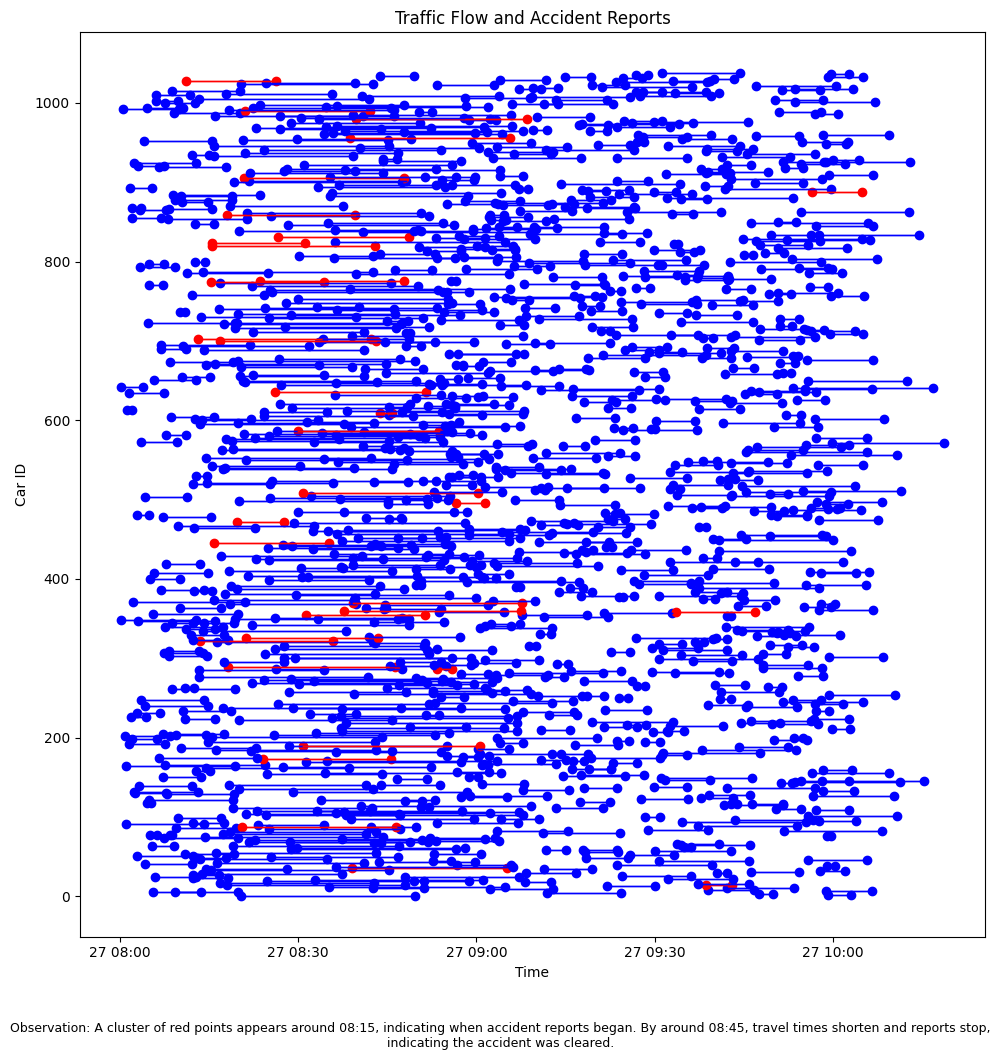

In [100]:
plt.figure(figsize=(10,10))

for car_id, car in sorted(car_data.items()):
    tA = car["tA"]
    tB = car["tB"]
    if not tA or not tB:
        continue

    # Point A
    colorA = "red" if car["reported"] else "blue"
    plt.scatter(tA, car_id, c=colorA, marker="o")
    plt.plot([tA, tB], [car_id, car_id], c=colorA, linewidth=1)

    # Point B
    colorB = "red" if car["reported"] else "blue"
    plt.scatter(tB, car_id, c=colorB, marker="o")
    plt.plot([tA, tB], [car_id, car_id], c=colorB, linewidth=1)

plt.xlabel("Time")
plt.ylabel("Car ID")
plt.title("Traffic Flow and Accident Reports")


caption = (
    "Observation: A cluster of red points appears around 08:15, indicating when accident reports began. "
    "By around 08:45, travel times shorten and reports stop, indicating the accident was cleared."
)
plt.figtext(0.5, -0.05, caption, wrap=True, ha="center", fontsize=9)

plt.tight_layout()

### Part 1 Step 2: Hypothesis Testing from Initial Reports

We want to test, in each 10-minute block of traffic:

* **Null hypothesis (H₀):** No accident, in which case we may get a residual level of reports (≈1%).
* **Alternative (H₁):** There is an accident, in which case accidents are reported at a rate of ≈10%.

**How to proceed:**

1. **Split the data** into non-overlapping 10-minute intervals.
2. For each interval, record:

   * $n$ = number of cars passing Point A
   * $r$ = number of initial accident reports
   * observed proportion $r/n$
3. **Model under H₀ (p = 0.01):**

   * Compute the probability of observing at least $r$ reports out of $n$.
   * Use this to compute the **p-value** for that interval.
4. If the p-value < 0.1 (90% confidence), **reject H₀** and conclude that an accident is detected in that interval.

**Reporting your results:**

* Extend your earlier plot by showing the observed proportion $r/n$ for each interval.
* Shade intervals **red** where H₀ is rejected at 90% confidence.
* In your lab report, clearly write the test criterion (p-value < 0.1) used to accept or reject the null hypothesis.

**Example shading code snippet:**

```python
for i, (start, end) in enumerate(intervals):
    if reject[i]:  # True if H0 rejected
        plt.axvspan(start, end, color="red", alpha=0.3)
```



**Discussion Questions:**

1. In which intervals did the hypothesis test reject $H_0$? Do these align with where you would visually expect accidents to occur?
2. How does the number of cars $n$ in an interval affect the reliability of the p-value?
3. What are the trade-offs of using a 90% confidence threshold instead of a stricter or looser one?
4. Could random noise in the reports cause false detections? How might you guard against this?



In [101]:
import datetime
from scipy.stats import binom

def split_into_intervals(car_data, interval_minutes=10):
    """Return list of (start, end) interval boundaries covering all cars."""
   
    all_times = [c["tA"] for c in car_data.values() if c["tA"] is not None] + \
                [c["tB"] for c in car_data.values() if c["tB"] is not None]
    if not all_times:
        return []

    start_time = min(all_times)
    end_time = max(all_times)

    intervals = []
    cur = start_time
    delta = datetime.timedelta(minutes=interval_minutes)
    while cur < end_time:
        intervals.append((cur, cur + delta))
        cur += delta

    return intervals
intervals = split_into_intervals(car_data)

In [102]:
from scipy.stats import binom

def test_intervals(car_data, intervals, alpha=0.1, p0=0.01):
   
    proportions, pvals, rejectH0Flags = [], [], []

    for (start, end) in intervals:
       
        cars_in_interval = [
            c for c in car_data.values()
            if c["tA"] is not None and start <= c["tA"] < end
        ]

        n = len(cars_in_interval)

       
        if n == 0:
            proportions.append(0)
            pvals.append(1.0)
            rejectH0Flags.append(False)
            continue

        
        r = sum(1 for c in cars_in_interval if c["reported"])
        p_hat = r / n

       
        p_value = 1 - binom.cdf(r - 1, n, p0)   
        reject = p_value < alpha

        proportions.append(p_hat)
        pvals.append(p_value)
        rejectH0Flags.append(reject)

    return proportions, pvals, rejectH0Flags



proportions, pvals, rejectH0Flags = test_intervals(car_data, intervals, alpha=0.1, p0=0.01)
print("Proportions:", proportions)
print("p-values:", pvals)
print("Reject flags:", rejectH0Flags)


Proportions: [0.0, 0.102803738317757, 0.09, 0.08888888888888889, 0.017241379310344827, 0.023255813953488372, 0.0, 0.0, 0.0, 0.023529411764705882, 0.0, 0.010309278350515464, 0, 0]
p-values: [np.float64(1.0), np.float64(1.283625117309839e-08), np.float64(8.385109673270108e-07), np.float64(3.740485211678468e-06), np.float64(0.441733861452136), np.float64(0.2126582717309885), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.2090042151160354), np.float64(1.0), np.float64(0.6227633530764954), 1.0, 1.0]
Reject flags: [np.False_, np.True_, np.True_, np.True_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, False, False]


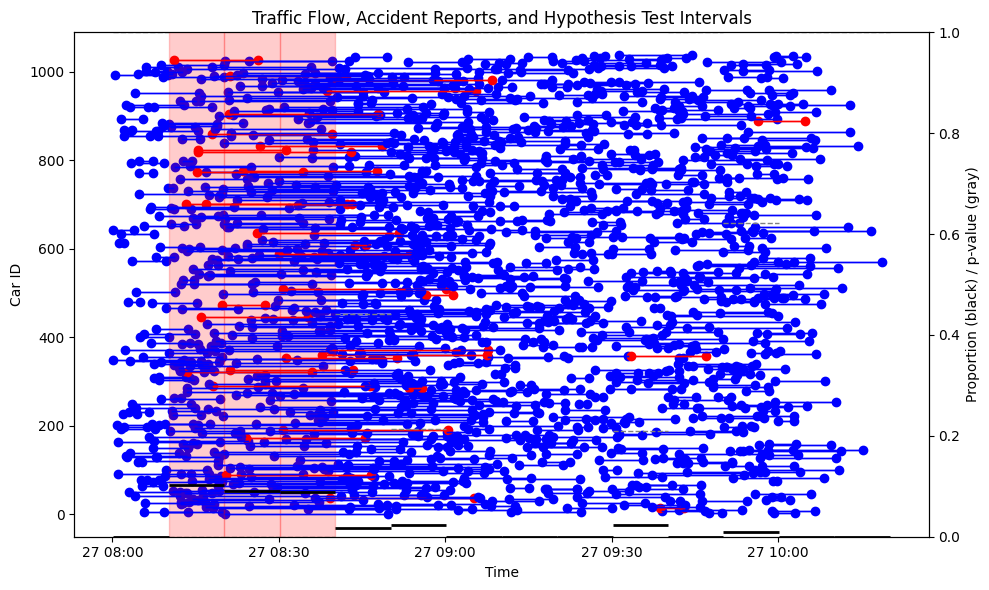

In [103]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))



for car_id, car in sorted(car_data.items()):
    tA = car["tA"]
    tB = car["tB"]
    if not tA or not tB:
        continue

    # Point A
    colorA = "red" if car["reported"] else "blue"
    plt.scatter(tA, car_id, c=colorA, marker="o")
    plt.plot([tA, tB], [car_id, car_id], c=colorA, linewidth=1)

    # Point B
    colorB = "red" if car["reported"] else "blue"
    plt.scatter(tB, car_id, c=colorB, marker="o")
    plt.plot([tA, tB], [car_id, car_id], c=colorB, linewidth=1)


# Shade intervals where H0 rejected
for (start, end), reject in zip(intervals, rejectH0Flags):
    if reject:
        ax1.axvspan(start, end, color="red", alpha=0.2)

ax1.set_xlabel("Time")
ax1.set_ylabel("Car ID", color="black")
ax1.tick_params(axis="y", labelcolor="black")


ax2 = ax1.twinx()
for (start, end), prop, pval in zip(intervals, proportions, pvals):
    
    ax2.hlines(y=prop, xmin=start, xmax=end, colors="black", linewidth=2)
    
    ax2.hlines(y=pval, xmin=start, xmax=end, colors="gray", linewidth=1, linestyles="--")

ax2.set_ylabel("Proportion (black) / p-value (gray)", color="black")
ax2.set_ylim(0, 1)
ax2.tick_params(axis="y", labelcolor="black")

plt.title("Traffic Flow, Accident Reports, and Hypothesis Test Intervals")
fig.tight_layout()



### Part 1 Step 3: Hypothesis Testing from Travel Times

Relying only on human reports can be unreliable — many drivers never report, even if they see an accident.
Another source of information is the **time it takes a vehicle to travel from Point A to Point B**.

We assume:

* **Null hypothesis (H0):** no accident. Travel times are normally distributed with mean = 5 minutes and variance = 1 minute.
* **Alternative hypothesis (H1):** an accident is present. Travel times are normally distributed with mean = 20 minutes and variance = 5 minutes.

**Procedure:**

1. **First analysis (scatter plot):**

   * Plot each car’s travel time against its exit time.
   * This lets you see the raw data: normally most cars cluster near 5 minutes, but during the accident window, many jump closer to 20 minutes.

2. **Intuition**
   * In the caption of the generated plot, make an educated guess as to when the accident started, and when it was cleared, using duration data.
   
3. **Interval-based test (overlay plot):**

   * Split the data into non-overlapping 10-minute intervals.
   * For each interval, compute the average travel time and plot it as a black horizontal line.
   * Also compute the p-value from a likelihood ratio test comparing H0 vs H1.
   * Plot these p-values as gray dashed lines on a second y-axis.

4. **Highlight accident detection:**

   * Shade intervals red where you reject H0 at the 90% confidence level.
   * The final plot shows:

     * Raw scatter points for individual travel times.
     * Interval averages (black lines).
     * P-values (gray dashed lines).
     * Shaded intervals where the system concludes “accident detected.”


5. **Discussion:**

   * Which approach gives a clearer signal of accidents: reports or travel times?
   * What are the trade-offs of relying on humans vnts can copy-paste and run each in sequence?
(\mathcal{N})” references)?
, so they directly match the hypotheses here?


In [104]:
import datetime
import numpy as np
from scipy.stats import norm, chi2
import matplotlib.pyplot as plt



def split_into_intervals(car_data, interval_minutes=10):
    
    all_times = [c["tB"] for c in car_data.values() if c["tB"] is not None]
    if not all_times:
        return []
    start_time = min(all_times)
    end_time = max(all_times)

    intervals = []
    cur = start_time
    delta = datetime.timedelta(minutes=interval_minutes)
    while cur < end_time:
        intervals.append((cur, cur + delta))
        cur += delta
    return intervals

def test_travel_intervals(car_data, intervals, alpha=0.1):
    
    means, pvals, rejectH0Flags = [], [], []

    for (start, end) in intervals:
        cars_in_interval = [
            c for c in car_data.values()
            if c["tB"] is not None and start <= c["tB"] < end and c["tA"] is not None
        ]

        n = len(cars_in_interval)

        if n == 0:
            means.append(0)
            pvals.append(1.0)
            rejectH0Flags.append(False)
            continue

        travel_times = [ (c["tB"] - c["tA"]).total_seconds() / 60.0 for c in cars_in_interval ]

        mean_tt = np.mean(travel_times)

        # H0: N(5, 1)
        # H1: N(20, 5)
        logL0 = np.sum(norm.logpdf(travel_times, loc=10, scale=1))
        logL1 = np.sum(norm.logpdf(travel_times, loc=20, scale=np.sqrt(5)))

        LRT = -2 * (logL0 - logL1)
        pval = chi2.sf(LRT, df=1)
        reject = pval < alpha

        means.append(mean_tt)
        pvals.append(pval)
        rejectH0Flags.append(reject)
    return means, pvals, rejectH0Flags



intervals = split_into_intervals(car_data)
means, pvals, rejectH0Flags = test_travel_intervals(car_data, intervals, alpha=0.1)

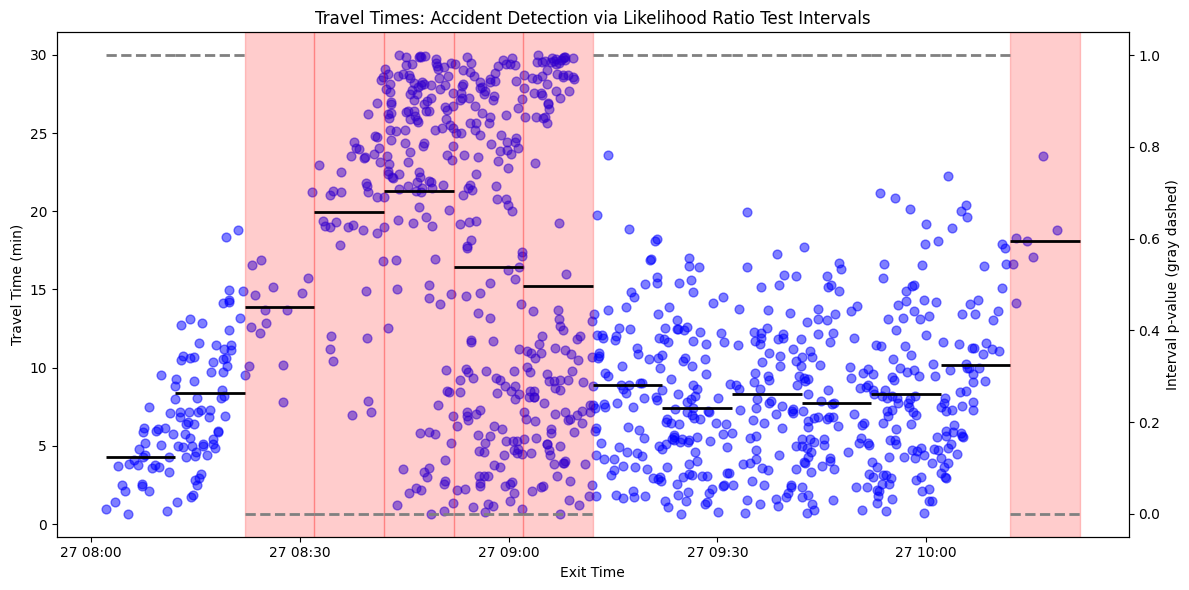

In [105]:

fig, ax1 = plt.subplots(figsize=(12, 6))


for car_id, car in sorted(car_data.items()):
    tA, tB = car["tA"], car["tB"]
    if not tA or not tB:
        continue
    travel_time = (tB - tA).total_seconds() / 60.0
    plt.scatter(tB, travel_time, color="blue", alpha=0.5, s=40)


for (start, end), mean, reject in zip(intervals, means, rejectH0Flags):
    if reject:
        ax1.axvspan(start, end, color="red", alpha=0.2)
    ax1.hlines(mean, start, end, colors="black", linewidth=2)

ax1.set_xlabel("Exit Time")
ax1.set_ylabel("Travel Time (min)", color="black")
ax1.tick_params(axis="y", labelcolor="black")


ax2 = ax1.twinx()
for (start, end), pval in zip(intervals, pvals):
    ax2.hlines(y=pval, xmin=start, xmax=end, colors="gray", linewidth=2, linestyles="--")
ax2.set_ylabel("Interval p-value (gray dashed)", color="black")


plt.title("Travel Times: Accident Detection via Likelihood Ratio Test Intervals")
fig.tight_layout()
plt.show()


    

## Part 2 – Accident Persistence (Tracking Vehicle Speeds)

* **Setup:** Once an accident is flagged, Maps continuously monitors the speeds of vehicles driving through the affected road segment. Each GPS measurement is noisy (due to device error, sampling frequency, or driver behavior).

* **Difference:** Unlike the initial reports, this is **structured numeric data** collected automatically in real time. Instead of “is there an accident?” the question becomes “are speeds still abnormally low compared to normal traffic flow?”

* **Questions to ponder:**

  * How many speed observations are needed before we can confidently say the accident is still causing delays?
  * How do we update our estimate of the “true mean speed” as new samples arrive?
  * At what point should we conclude speeds have returned to normal and clear the accident?

* **Tools:**

  * **Sequential Estimation:** update running estimates of the mean/variance of speeds as each new GPS report arrives.
  * **SPRT (Sequential Probability Ratio Test):** test whether the current mean speed is significantly below normal traffic speed. Stop sampling when evidence is sufficient.
  * **Time-series models (AR/ARIMA):** explicitly model the speed as an evolving process with noise, and forecast future duration, (e.g. give "estimated time until clearing accident area").
  

### Part 2  Step 1: Collect and Visualize Duration Data

Once the accident is flagged, we now focus on **vehicle durations** instead of reports. Each car’s duration is  

* (t_A) = time car passes Point A
* (t_B) = time car passes Point B
* duration = (travel time from A to B in hours)

**Instructions:**

1. For each car in your dataset, collect data in two arrays:

   * `x`: the entry time (t_A)
   * `y`: the estimated duration.

2. Make a scatter plot of `x` vs `y`:

   * x-axis = entry time
   * y-axis = speed (mph)
 
 


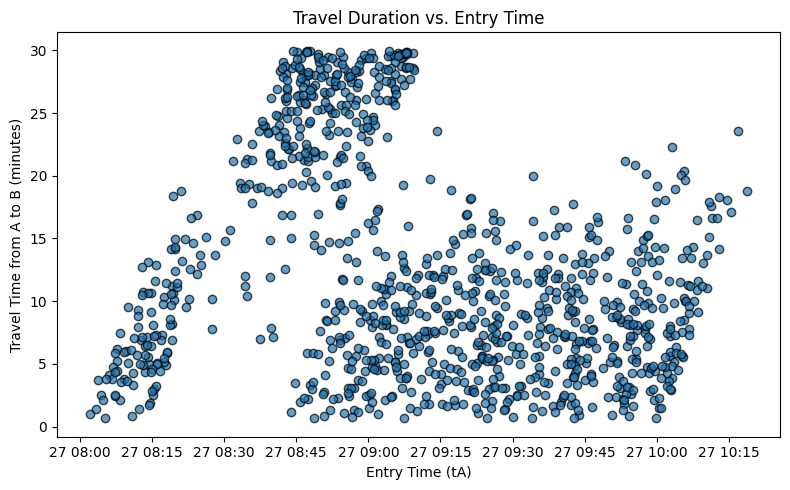

In [106]:
import matplotlib.pyplot as plt


x, y = [], []
for car_id, car in sorted(car_data.items()):
    tA = car["tA"]
    tB = car["tB"]
    if not tA or not tB:
        continue

    duration = (tB - tA).total_seconds() / 60.0  
    x.append(tB)
    y.append(duration)


# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.7, edgecolor="k")

plt.xlabel("Entry Time (tA)")
plt.ylabel("Travel Time from A to B (minutes)")
plt.title("Travel Duration vs. Entry Time")
plt.tight_layout()

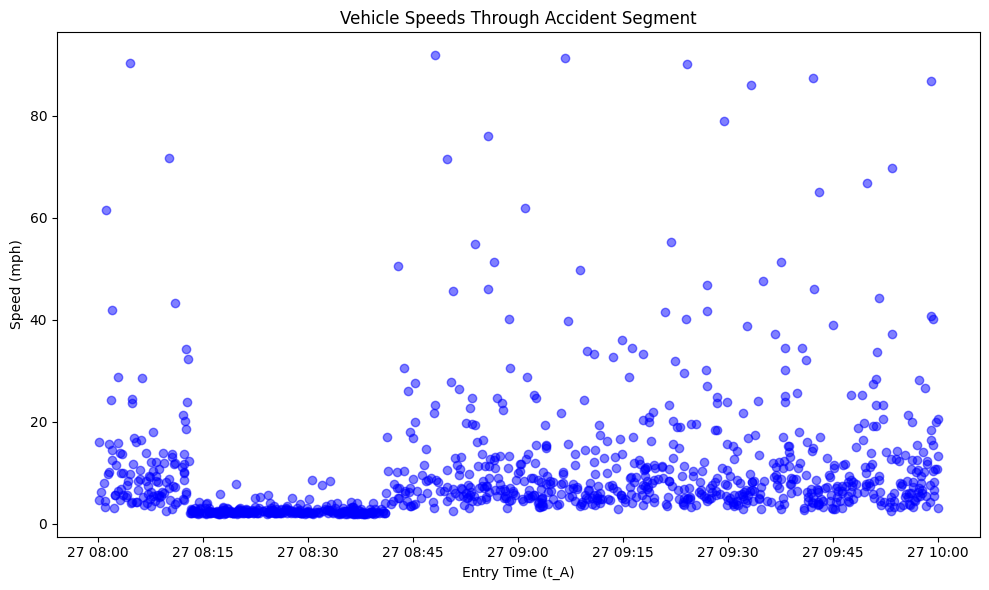

In [107]:
import matplotlib.pyplot as plt

segmentLength = 1.0  

x = []
y = []

for car_id, car in car_data.items():
    tA, tB = car.get("tA"), car.get("tB")
    if tA and tB:
        entry_time = tA
        durationHr = (tB - tA).total_seconds() / 3600.0
        speed_mph = segmentLength / durationHr  
        x.append(entry_time)
        y.append(speed_mph)

# plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, color="blue")
plt.xlabel("Entry Time (t_A)")
plt.ylabel("Speed (mph)")
plt.title("Vehicle Speeds Through Accident Segment")
plt.tight_layout()
plt.show()



### Part 2 Step 2: Sequential Estimation (Online Processing with Forgetting Factor)

We now want a good estimate of the speed of the vehicles (which we will monitor in terms of the time required to travel from Point A to Point B). However, instead of batch processing, imagine the system is running live: every time a car exits Point B, a new travel duration is observed. The system must update its estimate of the **mean travel duration** immediately, without re-processing all past data.

The following code first sorts the cars by their exit time (t_B), and then allows you to process cars one by one in order of (t_B). What you do:

1. At each new car:

   * Compute its travel duration in minutes = (t_B – t_A).
   * Update the running mean estimate using the forgetting factor rule (exponential moving average): mu_t = (1 - alpha)mu_{t-1} + alpha d_t.   
   * Additionally, implement a version where mu_t is the online updated true mean, e.g. mu_t = mu_{t-1} * (t-1)/t + d_t / t.

2. Plot  four cases (true mean, α = 0.0, 0.1, 0.5) together with the individual durations (scatter plot from before) to see how differently they react to changes.

3. Pick an alpha value (or use true mean that you think produces the best denoised mean estimate, to be used in the next step.


**Discussion Questions:**

1. How quickly did the SPRT detect an accident after travel times increased?
2. After the accident cleared, how many cars or how much time did it take before the test declared “normal traffic”?
3. Which type of error seems more serious in this application: a false alarm (detecting an accident too early) or a missed detection (failing to detect an accident)?
4. How would adjusting $\alpha$ or $\beta$ change the test’s sensitivity to accidents?
5. Did you observe intervals where the likelihood ratio oscillated between the thresholds without reaching a decision? What does this say about the uncertainty of the evidence?
6. What external signals (such as user reports, sensor data, or time of day) could be combined with travel times to improve accident detection?



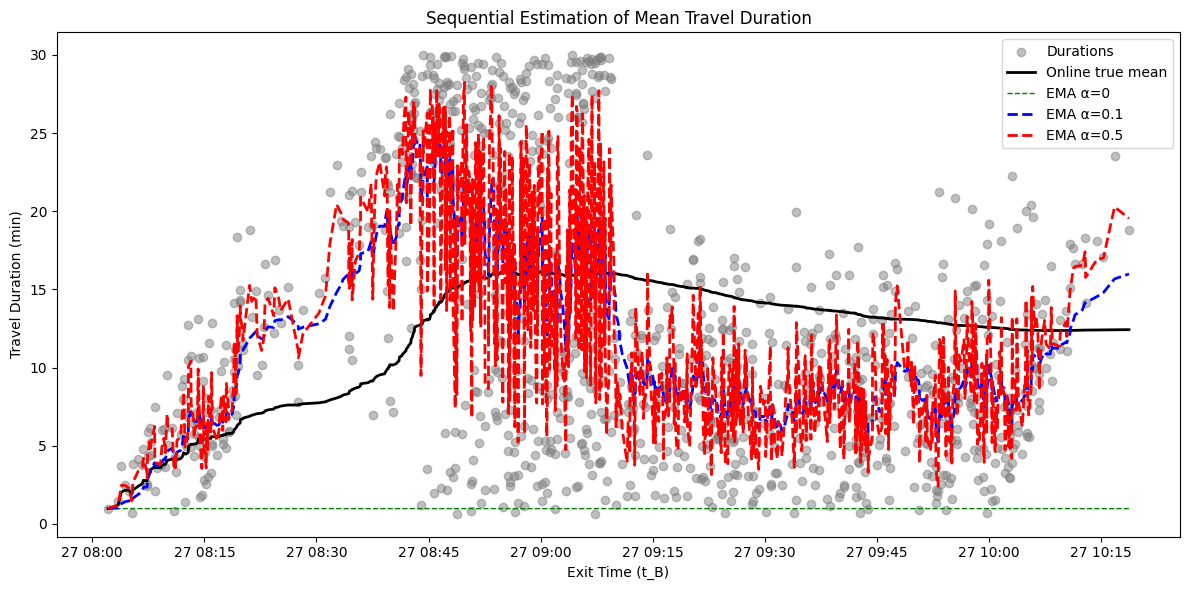

In [ ]:
import matplotlib.pyplot as plt



carList = [ (car_id, car["tA"], car["tB"]) 
            for car_id, car in car_data.items() if car["tA"] and car["tB"] ]
carList.sort(key=lambda x: x[2]) 

durations = [ (tB - tA).total_seconds() / 60.0 for _, tA, tB in carList ]  
tB_times = [ tB for _, _, tB in carList ]  


def exp_moving_avg(durations, alpha):
    ema = []
    mu = durations[0] if durations else 0
    for d in durations:
        mu = (1 - alpha) * mu + alpha * d
        ema.append(mu)
    return ema

def online_true_mean(durations):
    
    means = []
    mu = durations[0]
    for i, d in enumerate(durations):
        mu = mu * i/(i+1) + d/(i+1)
        means.append(mu)
    return means


mu_true = online_true_mean(durations)
mu_a0   = exp_moving_avg(durations, 0.0)
mu_a01  = exp_moving_avg(durations, 0.1)
mu_a05  = exp_moving_avg(durations, 0.5)

# Plot
plt.figure(figsize=(12, 6))
plt.scatter(tB_times, durations, alpha=0.5, color="gray", label="Durations")

plt.plot(tB_times, mu_true, color="black", linewidth=2, label="Online true mean")
plt.plot(tB_times, mu_a0, color="green", linestyle="--", linewidth=1, label="EMA α=0")
plt.plot(tB_times, mu_a01, color="blue", linestyle="--", linewidth=2, label="EMA α=0.1")
plt.plot(tB_times, mu_a05, color="red", linestyle="--", linewidth=2, label="EMA α=0.5")

plt.xlabel("Exit Time (t_B)")
plt.ylabel("Travel Duration (min)")
plt.title("Sequential Estimation of Mean Travel Duration")
plt.legend()
plt.tight_layout()
plt.show()

### Part 2 Step 3: Sequential Accident Detection with SPRT

We want to monitor car travel times in **real time** and decide:

* **Null hypothesis (H₀):** Normal traffic. Travel times follow a normal distribution with mean ≈ 5 minutes and std ≈ 2 minutes.
* **Alternative (H₁):** Accident present. Travel times follow a normal distribution with mean ≈ 20 minutes and std ≈ 5 minutes.

**How to proceed:**

1. **Split the data** into non-overlapping 10-minute macro-intervals (these are checkpoints for decisions).
2. Within each interval, **process cars sequentially** in order of their exit times $t_B$. For each car:

   * Compute duration = $t_B - t_A$ in minutes.
   * Evaluate the likelihood under each model:

     * $f_0 = \text{Normal}(5, 2)$ under H₀
     * $f_1 = \text{Normal}(20, 5)$ under H₁
   * Update the **log-likelihood ratio (LLR):**

     $$
     \log LR \; \leftarrow \; \log LR + \big( \log f_1 - \log f_0 \big)
     $$
3. At the end of each macro-interval, compare the cumulative likelihood ratio against two thresholds:

   * Upper threshold $A = \frac{1-\beta}{\alpha}$ → strong evidence for H₁ (accident).
   * Lower threshold $B = \frac{\beta}{1-\alpha}$ → strong evidence for H₀ (no accident / cleared).
     (Use $\alpha = 10^{-4}, \beta = 10^{-4}$. Work with log thresholds $\log A, \log B$).
4. **Decision logic:**

   * If state = “normal” and $\log LR \geq \log A$, declare **accident detected**.
   * If state = “accident” and $\log LR \leq \log B$, declare **accident cleared**.
   * Otherwise, continue collecting data.
5. Reset $\log LR = 0$ at the end of each macro-interval to start fresh.

**Reporting your results:**

* On the top panel, plot individual car travel durations and mark macro-interval boundaries.
* On the bottom panel, plot likelihood ratios at decision times:

  * Blue points = accumulating evidence while in “normal” state.
  * Purple points = accumulating evidence while in “accident” state.
* Add horizontal lines for thresholds $A$ and $B$.
* Mark vertical dashed lines at times of **decisions** (accident detected / cleared).



**Discussion:**

1. How quickly did the SPRT detect an accident after travel times increased?

   * Was the detection immediate, or did it require several cars to accumulate evidence?

2. After the accident cleared, how many cars (or how much time) did it take before the test crossed the lower threshold and declared “normal traffic”?

   * Was there a noticeable lag in clearing detection?

3. Compare the trade-off between false alarms and missed detections:

   * Which type of error (false accident vs. missed accident) seems more serious in this application?
   * How would adjusting $\alpha$ or $\beta$ change the test’s sensitivity?

4. Did you observe intervals where the likelihood ratio oscillated between the thresholds without reaching a decision?

   * What does this say about the uncertainty of the evidence?

5. In practice, what external signals (e.g., user reports, sensor data, time of day) could be combined with travel times to improve accident detection reliability?


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime


mu0, sigma0 = 8, 2      # Normal traffic: mean 8 min, std 2 min
mu1, sigma1 = 20, 5     # Accident: mean 20 min, std 5 min

alpha = 1e-4
beta = 1e-4

A = (1 - beta) / alpha
B = beta / (1 - alpha)

logA = np.log(A)
logB = np.log(B)



carList = [ (car_id, car["tA"], car["tB"]) 
    for car_id, car in car_data.items() if car["tA"] and car["tB"] ]
carList.sort(key=lambda x: x[2])   # Sort by tB (exit time)


start_time = min(tB for _, _, tB in carList)
end_time = max(tB for _, _, tB in carList)

interval_minutes = 10
intervals = []
cur = start_time
while cur < end_time:
    intervals.append( (cur, cur + datetime.timedelta(minutes=interval_minutes)) )
    cur += datetime.timedelta(minutes=interval_minutes)
interval_boundaries = [ iv[0] for iv in intervals ]

# SPRT processing

top_x, top_y = [], []    
llr_times, llr_vals, llr_states = [], [], []
decision_times = []
decision_types = []  
state = "normal"     

for interval in intervals:
    logLR = 0.0
    

    cars_in_interval = [ (car_id, tA, tB) for car_id, tA, tB in carList if interval[0] <= tB < interval[1] ]
    for car_id, tA, tB in cars_in_interval:
        duration = (tB - tA).total_seconds() / 60.0
        top_x.append(tB)
        top_y.append(duration)


      
        logf0 = norm.logpdf(duration, loc=mu0, scale=sigma0)
        logf1 = norm.logpdf(duration, loc=mu1, scale=sigma1)

        logLR += (logf1 - logf0)

        llr_times.append(tB)
        llr_vals.append(logLR)
        llr_states.append(state)


        # Decision logic
        if state == "normal" and logLR >= logA:
            decision_times.append(tB)
            decision_types.append("accident")
            state = "accident"
        elif state == "accident" and logLR <= logB:
            decision_times.append(tB)
            decision_types.append("cleared")
            state = "normal"
    


    logLR = 0.0 # Reset LLR for next macro-interval

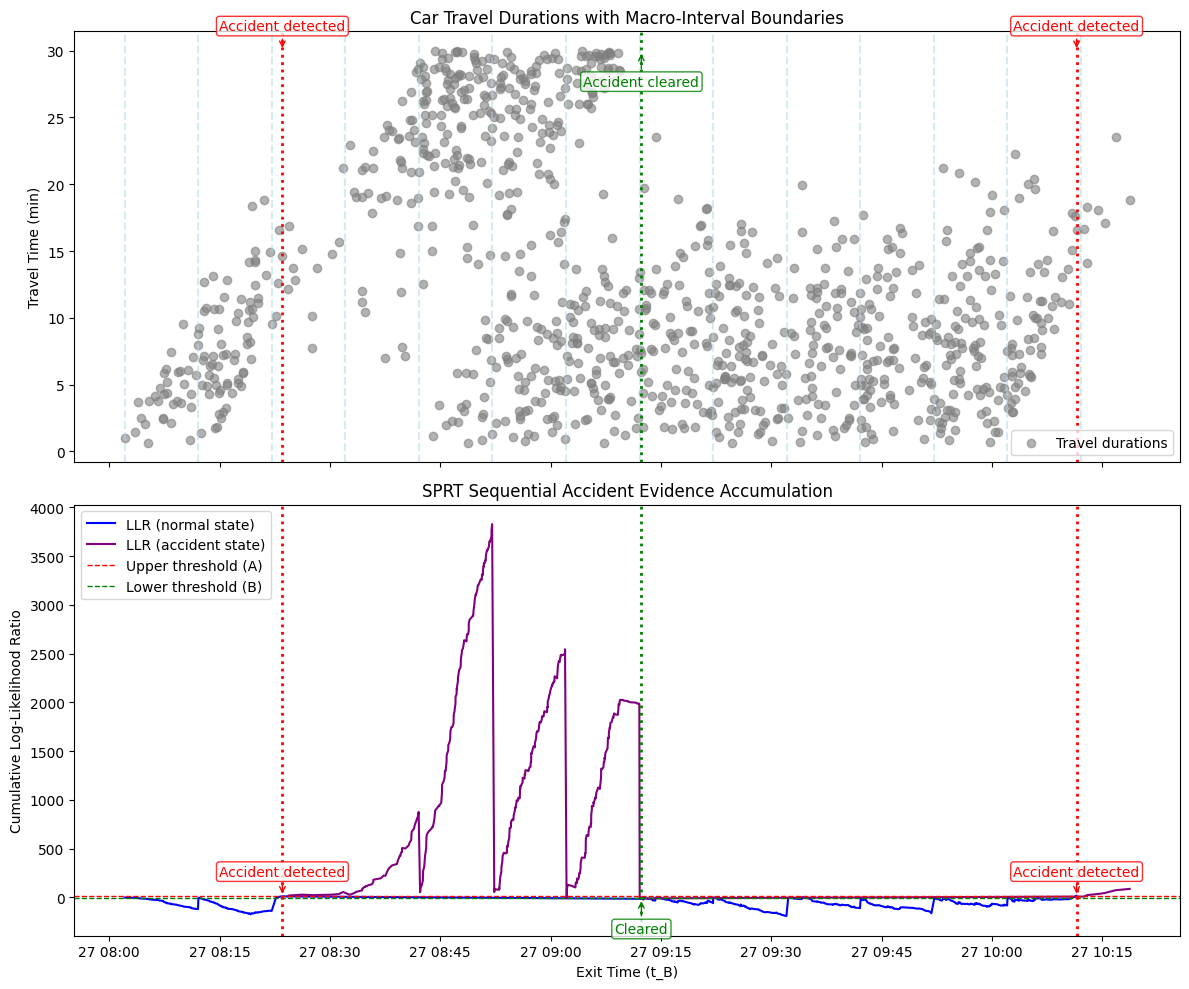

In [110]:

fig, (ax_top, LLRAxis) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)


ax_top.scatter(top_x, top_y, color="gray", alpha=0.6, label="Travel durations")

for b in interval_boundaries:
    ax_top.axvline(b, color="lightblue", linestyle="--", alpha=0.5)
ax_top.set_ylabel("Travel Time (min)")
ax_top.set_title("Car Travel Durations with Macro-Interval Boundaries")
ax_top.legend()



for t, typ in zip(decision_times, decision_types):
    msg = "Accident detected" if typ == "accident" else "Accident cleared"
    color = "red" if typ == "accident" else "green"
    ax_top.axvline(t, color=color, linestyle=":", linewidth=2)
    ax_top.annotate(msg,
                   xy=(t, max(top_y)),
                   xytext=(0, 15 if typ=="accident" else -25),
                   textcoords='offset points',
                   ha='center',
                   color=color,
                   fontsize=10,
                   arrowprops=dict(arrowstyle="->", color=color, lw=1),
                   bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8, ec=color))


normal_x = [llr_times[i] for i in range(len(llr_states)) if llr_states[i]=="normal"]
normal_y = [llr_vals[i] for i in range(len(llr_states)) if llr_states[i]=="normal"]
acc_x = [llr_times[i] for i in range(len(llr_states)) if llr_states[i]=="accident"]
acc_y = [llr_vals[i] for i in range(len(llr_states)) if llr_states[i]=="accident"]

LLRAxis.plot(normal_x, normal_y, color="blue", label="LLR (normal state)")
LLRAxis.plot(acc_x, acc_y, color="purple", label="LLR (accident state)")

LLRAxis.axhline(logA, color="red", linestyle="--", linewidth=1, label="Upper threshold (A)")
LLRAxis.axhline(logB, color="green", linestyle="--", linewidth=1, label="Lower threshold (B)")


for t, typ in zip(decision_times, decision_types):
    color = "red" if typ == "accident" else "green"
    msg = "Accident detected" if typ == "accident" else "Cleared"
    LLRAxis.axvline(t, color=color, linestyle=":", linewidth=2)
    LLRAxis.annotate(msg,
                    xy=(t, logA if typ=="accident" else logB),
                    xytext=(0, 15 if typ=="accident" else -25),
                    textcoords='offset points',
                    ha='center',
                    color=color,
                    fontsize=10,
                    arrowprops=dict(arrowstyle="->", color=color, lw=1),
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.8, ec=color))
LLRAxis.set_ylabel("Cumulative Log-Likelihood Ratio")
LLRAxis.set_xlabel("Exit Time (t_B)")
LLRAxis.set_title("SPRT Sequential Accident Evidence Accumulation")
LLRAxis.legend()


plt.tight_layout()
plt.show()

### Part 2 Step 4: Rolling Forecasts with AR / ARMA / ARIMA

We want to use **time-series models** to forecast travel times during and after an accident, in order to estimate when traffic will return to normal. These models explicitly capture correlation across time and allow rolling predictions.

* **Goal:** Fit AR, ARMA, and ARIMA models at the end of each 10-minute interval, and forecast the next 10 minutes of travel times.
* **Models considered:**

  * AR (AutoRegressive): lags = 1, 2, 5
  * ARMA (AutoRegressive + Moving Average): (2,1), (2,3)
  * ARIMA (AutoRegressive + Integrated + Moving Average): (2,d,2) with d = 0, 1, 2


1. **Split the data** into non-overlapping 10-minute macro-intervals.
2. At the end of each macro-interval:

   * Collect all past durations observed so far.
   * Fit each candidate model (AR, ARMA, ARIMA) to this data.
   * Forecast the next 10 minutes of travel times.
3. **Store forecasts** with their timestamps for later plotting.

**Reporting your results:**

* Create a 3-panel figure with subplots:

  * **Top panel:** AR forecasts with lags 1, 2, 5.
  * **Middle panel:** ARMA forecasts with q = 1, 3.
  * **Bottom panel:** ARIMA forecasts with d = 0, 1, 2.
* In each panel:

  * Plot observed durations in **light blue circles**.
  * Overlay forecasts from all models in that family, each with a distinct color.
  * Add vertical dashed lines at the end of each macro-interval.
  * Draw a horizontal green line at 5 minutes to represent “normal traffic baseline.”

---

**Discussion:**

After generating forecasts, interpret the results:

* Do AR models with short vs. long lags respond differently to sudden drops?
* Do ARMA models smooth out noise better than AR alone?
* Does differencing in ARIMA (d = 0, 1, 2) make clearing forecasts more realistic, or does it over-smooth?
* Reflect on which family (AR, ARMA, ARIMA) provides the **most stable** vs. the **most reactive** estimate of accident clearing.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg


cars_sorted = sorted(car_data.values(), key=lambda c: c["tB"])
x = [car['tB'] for car in cars_sorted]
y = [(car['tB'] - car['tA']).total_seconds() / 60.0 for car in cars_sorted]


macro_intervals = split_into_intervals(car_data, interval_minutes=10)

steps = 10        # forecast 10 minutes

# === Helper functions ===
def fit_ar(ydata, lags=2, steps=10):
    model = AutoReg(ydata, lags=lags, old_names=False)
    model_fit = model.fit()
    return model_fit.forecast(steps=steps)

def fit_arma(ydata, order=(2,2), steps=10):
    model = ARIMA(ydata, order=(order[0], 0, order[1]))
    model_fit = model.fit()
    return model_fit.forecast(steps=steps)

def fit_arima(ydata, order=(2,1,2), steps=10):
    model = ARIMA(ydata, order=order)
    model_fit = model.fit()
    return model_fit.forecast(steps=steps)

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

cars_sorted = sorted(car_data.values(), key=lambda c: c["tB"])
x = [car['tB'] for car in cars_sorted]
y = [(car['tB'] - car['tA']).total_seconds() / 60.0 for car in cars_sorted]
macro_intervals = split_into_intervals(car_data, interval_minutes=10)


steps = 10  # forecast 10 next points per interval


ARforecasts = {1: [], 2: [], 5: []}
ARMAforecasts = {(2,1): [], (2,3): []}
ARIMAforecasts = {0: [], 1: [], 2: []}
forecast_times = []


def add_minutes(base_time, mins):
    return base_time + pd.Timedelta(minutes=mins)


for i, (start, end) in enumerate(macro_intervals):
   
    y_up_to_now = [ y[j] for j, t in enumerate(x) if t < end ]
    if len(y_up_to_now) < 10:
        continue  
    last_time = end

   
    future_times = [add_minutes(last_time, k+1) for k in range(steps)]
    forecast_times.append(future_times)

    # AR models
    for lag in [1, 2, 5]:
        try:
            preds = fit_ar(y_up_to_now, lags=lag, steps=steps)
            ARforecasts[lag].append(preds)
        except Exception:
            ARforecasts[lag].append([np.nan]*steps)

    # ARMA models
    for order in [(2,1), (2,3)]:
        try:
            preds = fit_arma(y_up_to_now, order=order, steps=steps)
            ARMAforecasts[order].append(preds)
        except Exception:
            ARMAforecasts[order].append([np.nan]*steps)

    # ARIMA models
    for d in [0, 1, 2]:
        try:
            preds = fit_arima(y_up_to_now, order=(2,d,2), steps=steps)
            ARIMAforecasts[d].append(preds)
        except Exception:
            ARIMAforecasts[d].append([np.nan]*steps)


obs_times = pd.to_datetime(x)
obs_y = np.array(y)
forecast_times_flat = np.array(forecast_times).flatten()

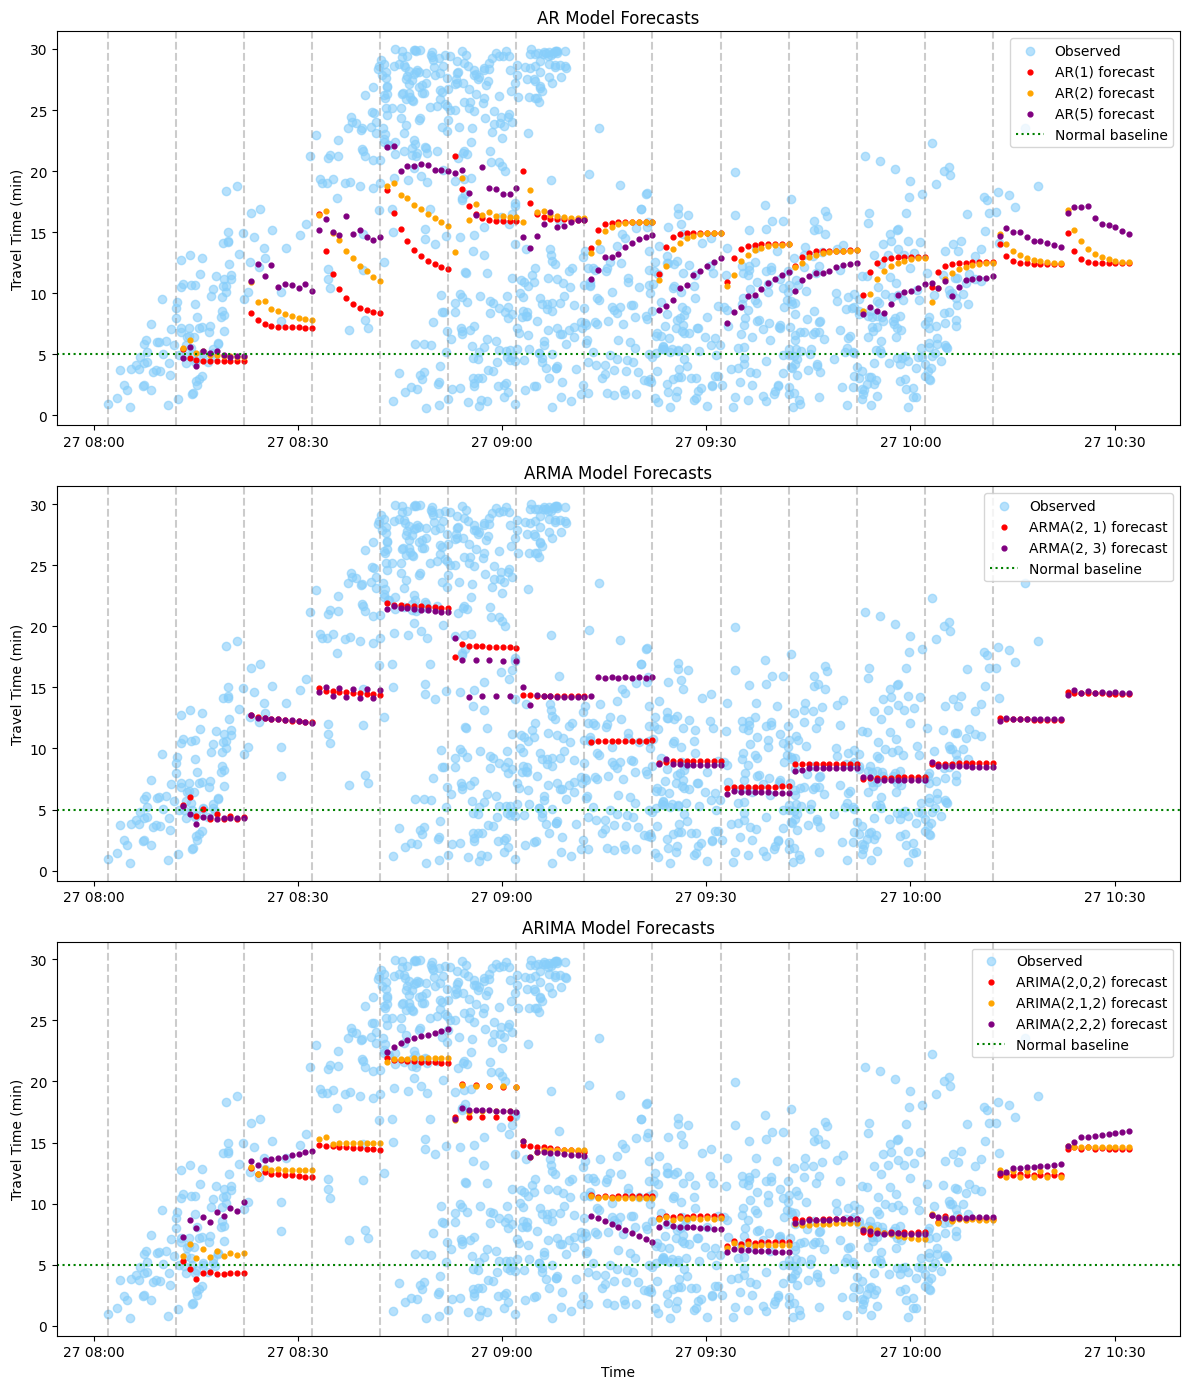

In [113]:
plt.figure(figsize=(12,14))


##### AR #####
plt.subplot(3,1,1)
plt.scatter(obs_times, obs_y, color="lightskyblue", label="Observed", alpha=0.6)

colors = {1: "red", 2: "orange", 5: "purple"}
for lag in [1, 2, 5]:
    preds = np.array(ARforecasts[lag]).flatten()
    plt.scatter(forecast_times_flat, preds, s=12, color=colors[lag], label=f"AR({lag}) forecast")

for (start, end) in macro_intervals:
    plt.axvline(start, color="gray", linestyle="--", alpha=0.4)
plt.axhline(5, color="green", linestyle=":" , label="Normal baseline")
plt.ylabel("Travel Time (min)")
plt.title("AR Model Forecasts")
plt.legend()


##### ARMA #####
plt.subplot(3,1,2)
plt.scatter(obs_times, obs_y, color="lightskyblue", label="Observed", alpha=0.6)
colors = {(2,1): "red", (2,3): "purple"}

for order in [(2,1), (2,3)]:
    preds = np.array(ARMAforecasts[order]).flatten()
    plt.scatter(forecast_times_flat, preds, s=12, color=colors[order], label=f"ARMA{order} forecast")

for (start, end) in macro_intervals:
    plt.axvline(start, color="gray", linestyle="--", alpha=0.4)

plt.axhline(5, color="green", linestyle=":" , label="Normal baseline")
plt.ylabel("Travel Time (min)")
plt.title("ARMA Model Forecasts")
plt.legend()


##### ARIMA #####
plt.subplot(3,1,3)
plt.scatter(obs_times, obs_y, color="lightskyblue", label="Observed", alpha=0.6)
colors = {0: "red", 1: "orange", 2: "purple"}

for d in [0,1,2]:
    preds = np.array(ARIMAforecasts[d]).flatten()
    plt.scatter(forecast_times_flat, preds, s=12, color=colors[d], label=f"ARIMA(2,{d},2) forecast")

for (start, end) in macro_intervals:
    plt.axvline(start, color="gray", linestyle="--", alpha=0.4)

plt.axhline(5, color="green", linestyle=":" , label="Normal baseline")
plt.ylabel("Travel Time (min)")
plt.title("ARIMA Model Forecasts")
plt.legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()

## Part 3 – Accident Start and Clearance (Changepoint Detection)

* **Setup:** Accidents cause a **distribution shift** in the data — either in reports (yes/no accident) or in travel durations (slow vs. normal). At some later time, the accident clears and the data shifts back toward normal.

* **Goal:** Detect **both** when the accident starts and when it clears, treating these moments as changepoints in the time series.

**Outline of how we will  proceed:**

1. Represent the data as a time series:

   * Binary reports (1 = accident reported, 0 = no report), or
   * Continuous durations (minutes from A to B).
2. Apply multiple changepoint detection methods to the series:

   * **CUSUM test** – detect mean shifts by monitoring cumulative sums.
   * **Page-Hinkley test** – detect changes in average level sequentially.
   * **PELT algorithm** – find changepoints by minimizing a global cost function.
3. For each method, identify:

   * The first changepoint flagged when traffic deviates from normal → **accident start**.
   * The next changepoint flagged when traffic returns to normal → **accident clearance**.


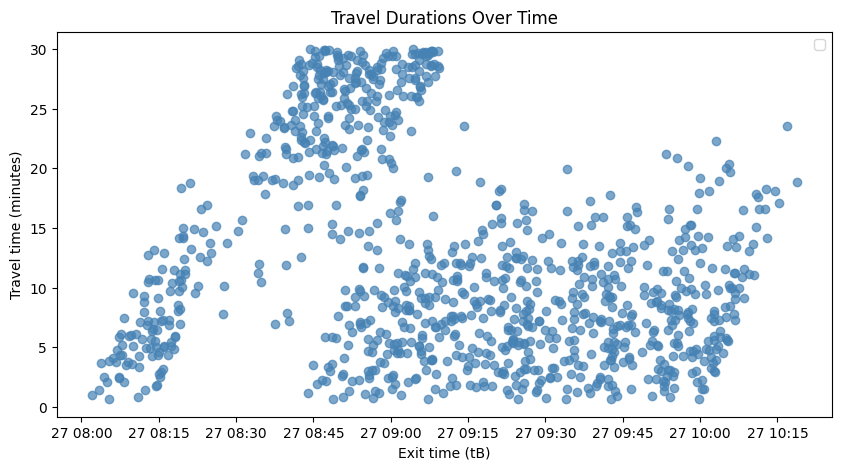

In [114]:
cars_sorted = sorted(car_data.values(), key=lambda c: c["tB"])
x = [c["tB"] for c in cars_sorted]  
y = [(c["tB"] - c["tA"]).total_seconds() / 60.0 for c in cars_sorted]
x, y = np.array(x), np.array(y)

plt.figure(figsize=(10,5))
plt.scatter(x, y, color="steelblue", alpha=0.7)
plt.title("Travel Durations Over Time")
plt.xlabel("Exit time (tB)")
plt.ylabel("Travel time (minutes)")
plt.legend()


### Part 3 Step 1: CUSUM

Let us begin by implementing one of the more straightforward changepoint detection methods.

**CUSUM idea:**

We maintain statistics that accumulate deviations of the data from a baseline mean:

$$
S_t^+ = \max{0, S_{t-1}^+ + (x_t - \mu)}, \qquad
S_t^- = \max{0, S_{t-1}^- - (x_t - \mu)},
$$

where (x_t) is the observation at time (t) and (\mu) is the reference mean.

* (S_t^+) is sensitive to upward shifts (e.g., longer travel times).
* (S_t^-) is sensitive to downward shifts (e.g., shorter travel times).

If either statistic exceeds a threshold (h), we declare a changepoint.

---

**Your coding task:**

1. Write a function `detect_cusum(y, mu, h)` with the following structure:

   * **Inputs:**

     * `y`: array of observed durations (minutes).
     * `mu`: reference mean (normal travel time, e.g., 5).
     * `h`: threshold for detection (larger (h) = fewer changepoints).

   * **Outputs:**

     * A list of indices where changepoints are detected.
     * Sequences of (S^+), (S^-), and the evolving mean estimate.

2. First, implement CUSUM with a **fixed baseline mean** (\mu).
   Then extend it to use a **running average for (\mu)** with a small decay factor (as you did earlier in the lab).
   *The running average lets the baseline adapt slowly to recent data rather than staying fixed.*

3. For each case, track **both (S^+) and (S^-)** over time.

4. Plot the results:

   * Plot the car durations (y) against their exit times (t_B).
   * Overlay the evolving mean (\mu_t).
   * Plot the two statistics (S^+) and (S^-).
   * Overlay vertical dashed lines at detected changepoints.
   * Repeat for 3 different values of (h).

---

**Discussion:**
In the report, discuss:

* How sensitive detection is to the choice of (h).
* How results differ when using a fixed mean vs. a running average.
* Why tracking both upward and downward deviations can be useful.


In [115]:

# y: array of durations (minutes)
# muInit: initial mean
# h: detection threshold
# running: if True, use running mean as reference, else fixed
# alpha: forgetting factor for running mean

def detect_cusum(y, muInit, h, running=False, alpha=0.01):
   
    S_pos, S_neg, changepoints = [], [], []
    muHist = []
    S_t_pos = 0.0
    S_t_neg = 0.0
    mu = muInit
    for t, x in enumerate(y):

        if running and t > 0:
            mu = (1 - alpha)*mu + alpha*x
        muHist.append(mu)
        S_t_pos = max(0, S_t_pos + (x - mu))
        S_t_neg = max(0, S_t_neg - (x - mu))
        S_pos.append(S_t_pos)
        S_neg.append(S_t_neg)

        if S_t_pos > h or S_t_neg > h:
            changepoints.append(t)
            S_t_pos = 0
            S_t_neg = 0
    return changepoints, np.array(S_pos), np.array(S_neg), np.array(muHist)

<Figure size 1300x700 with 0 Axes>

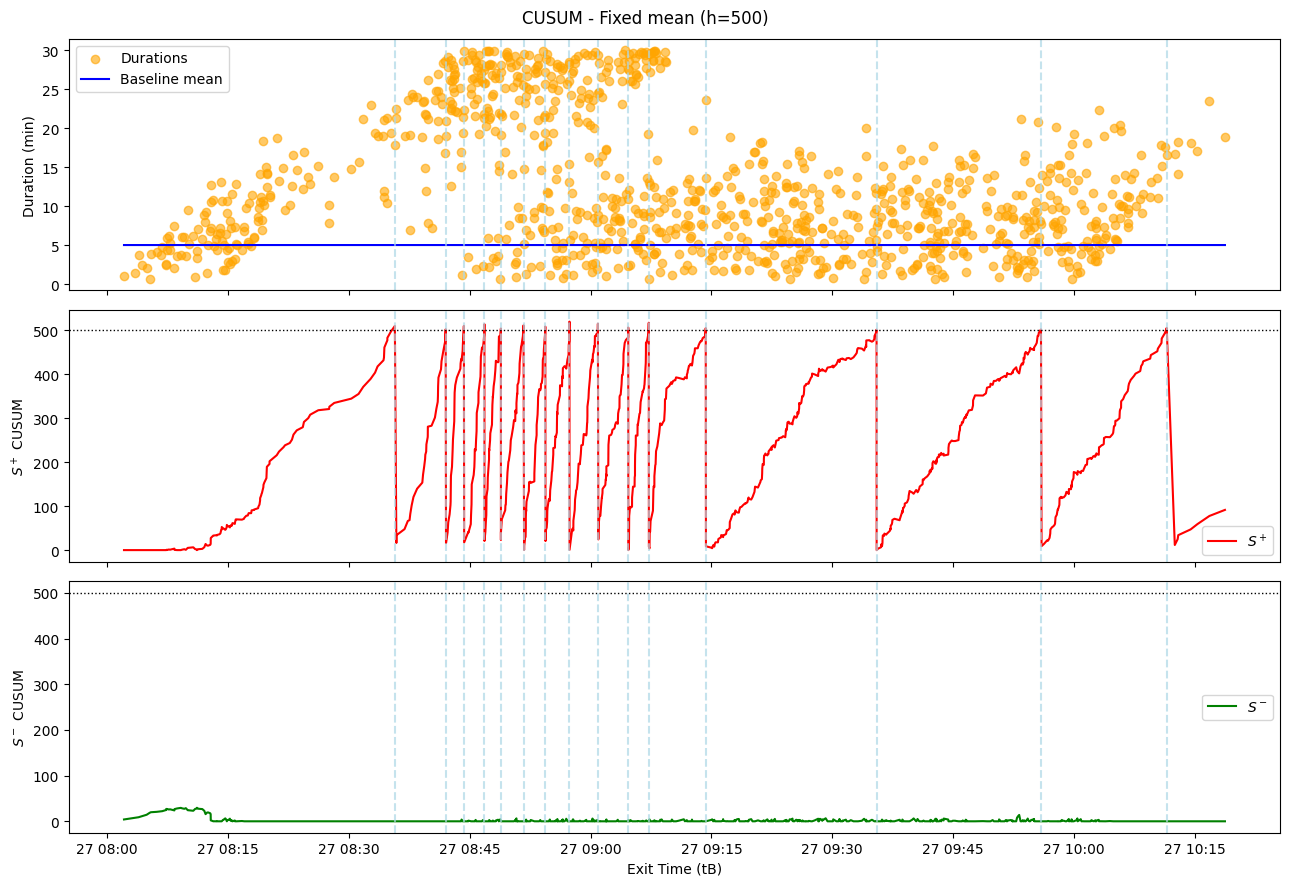

<Figure size 640x480 with 0 Axes>

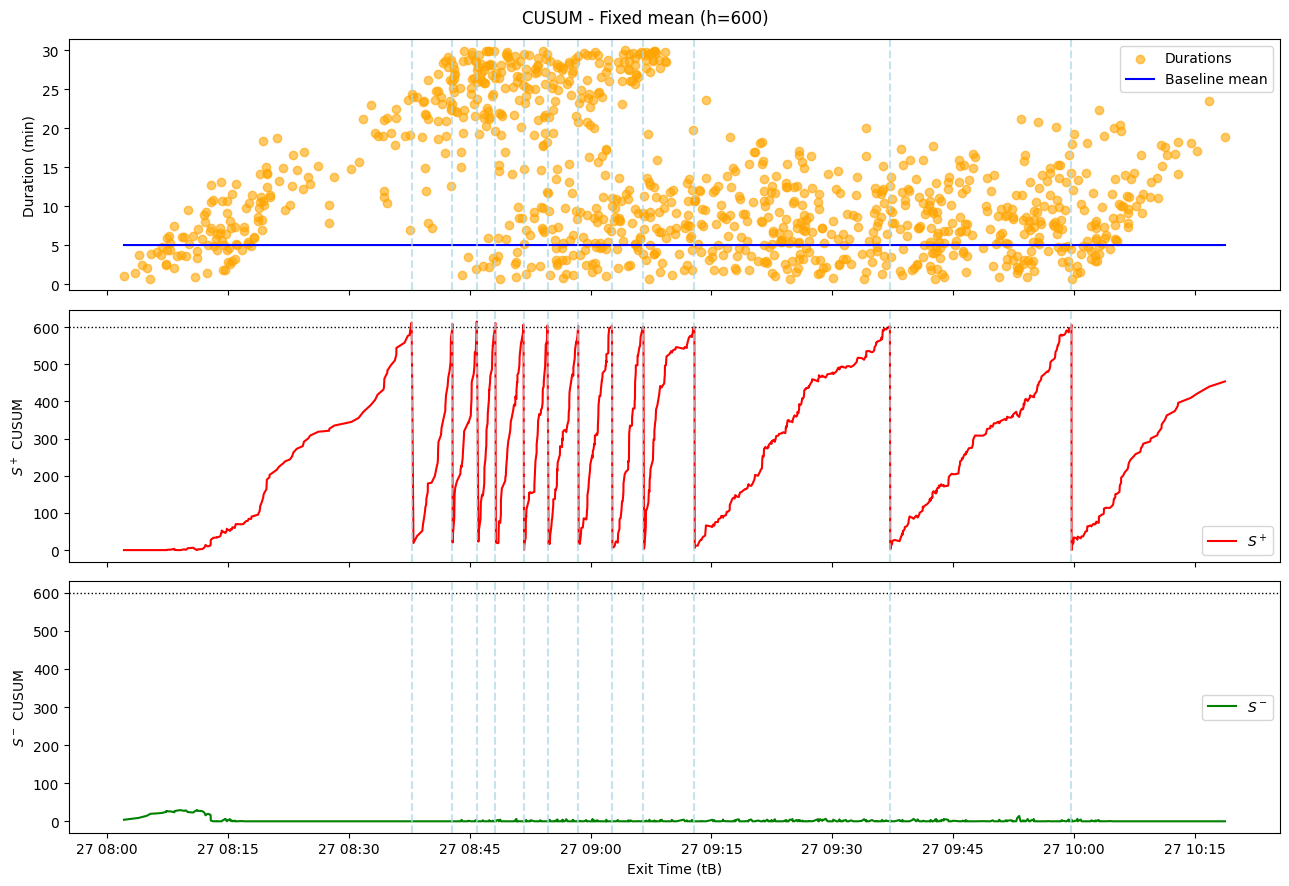

<Figure size 640x480 with 0 Axes>

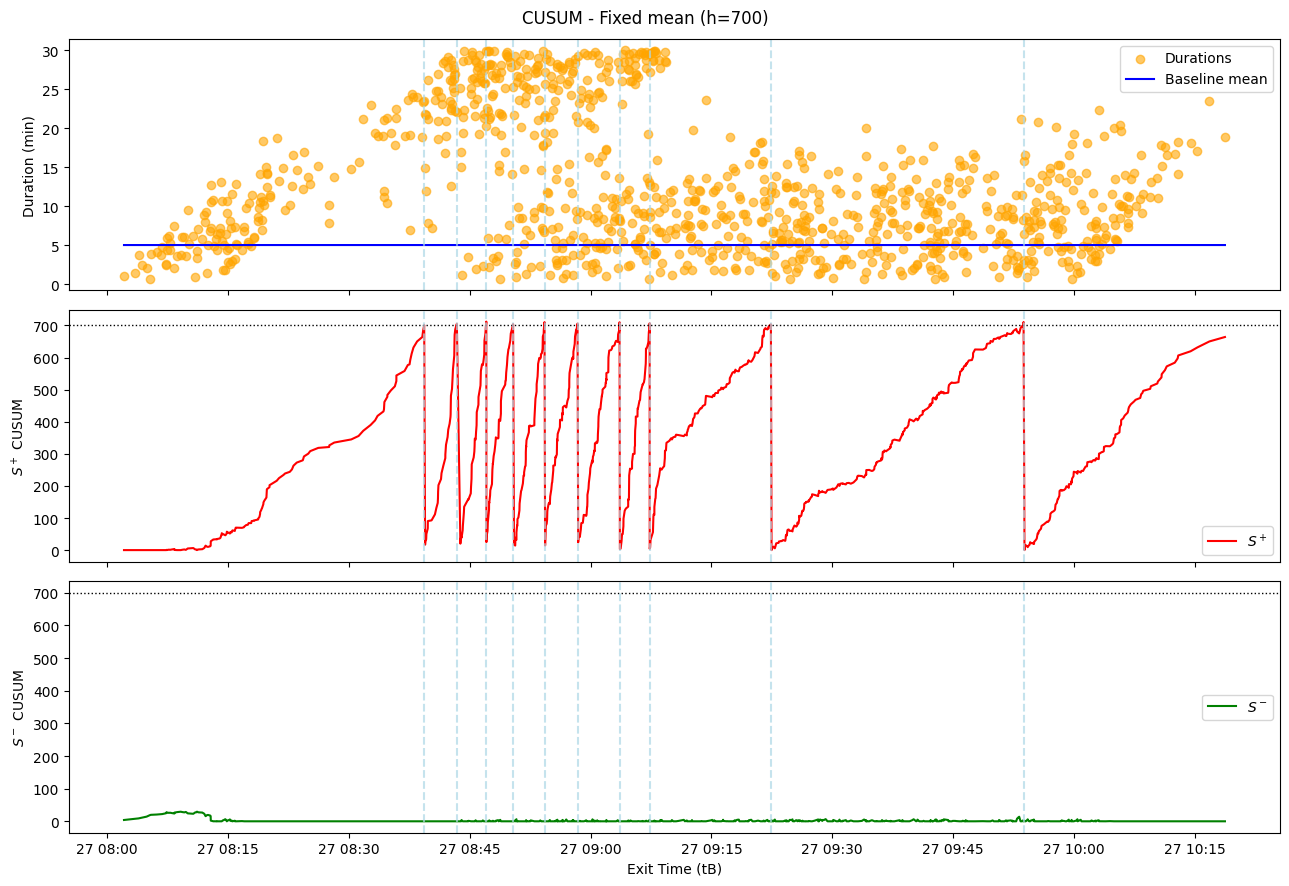

<Figure size 1300x700 with 0 Axes>

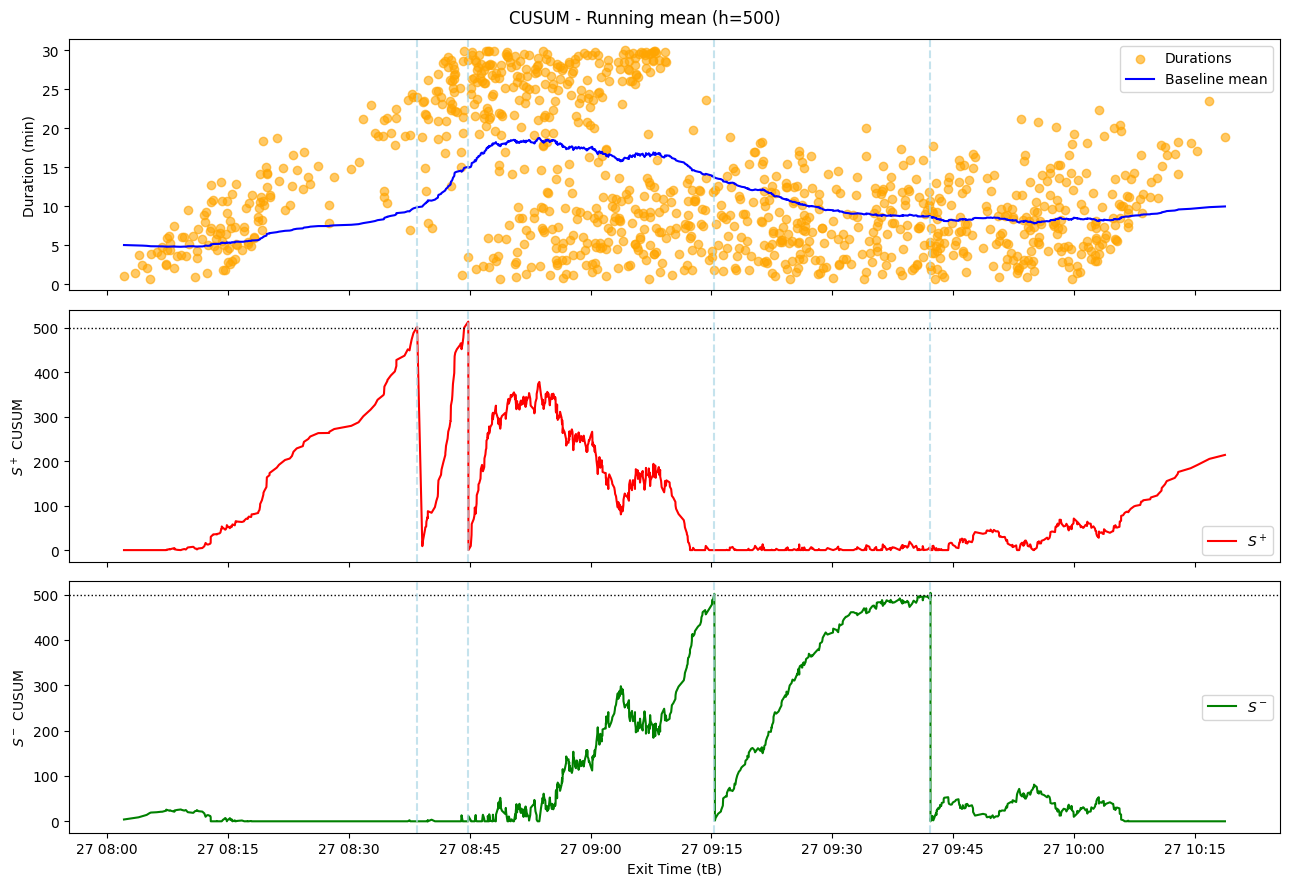

<Figure size 640x480 with 0 Axes>

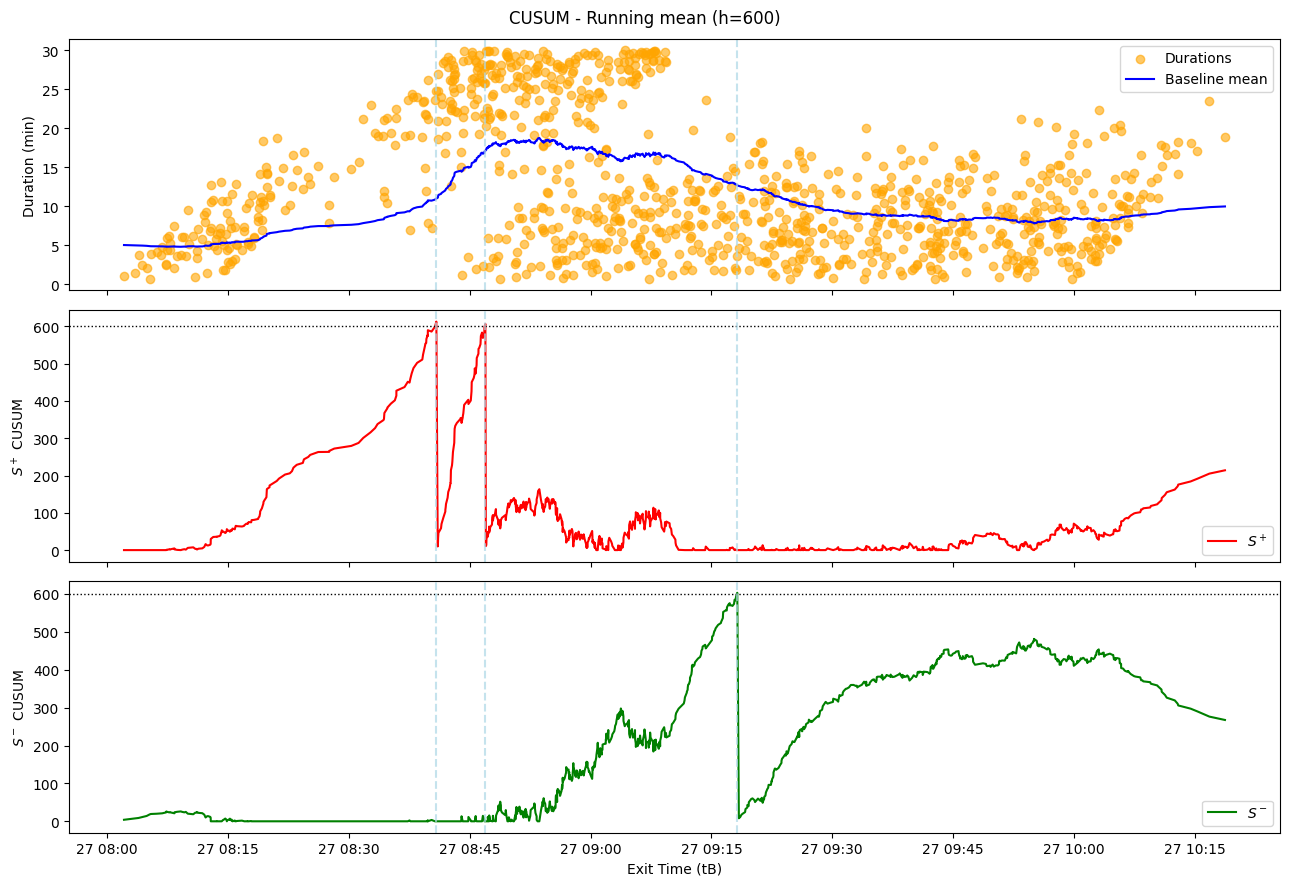

<Figure size 640x480 with 0 Axes>

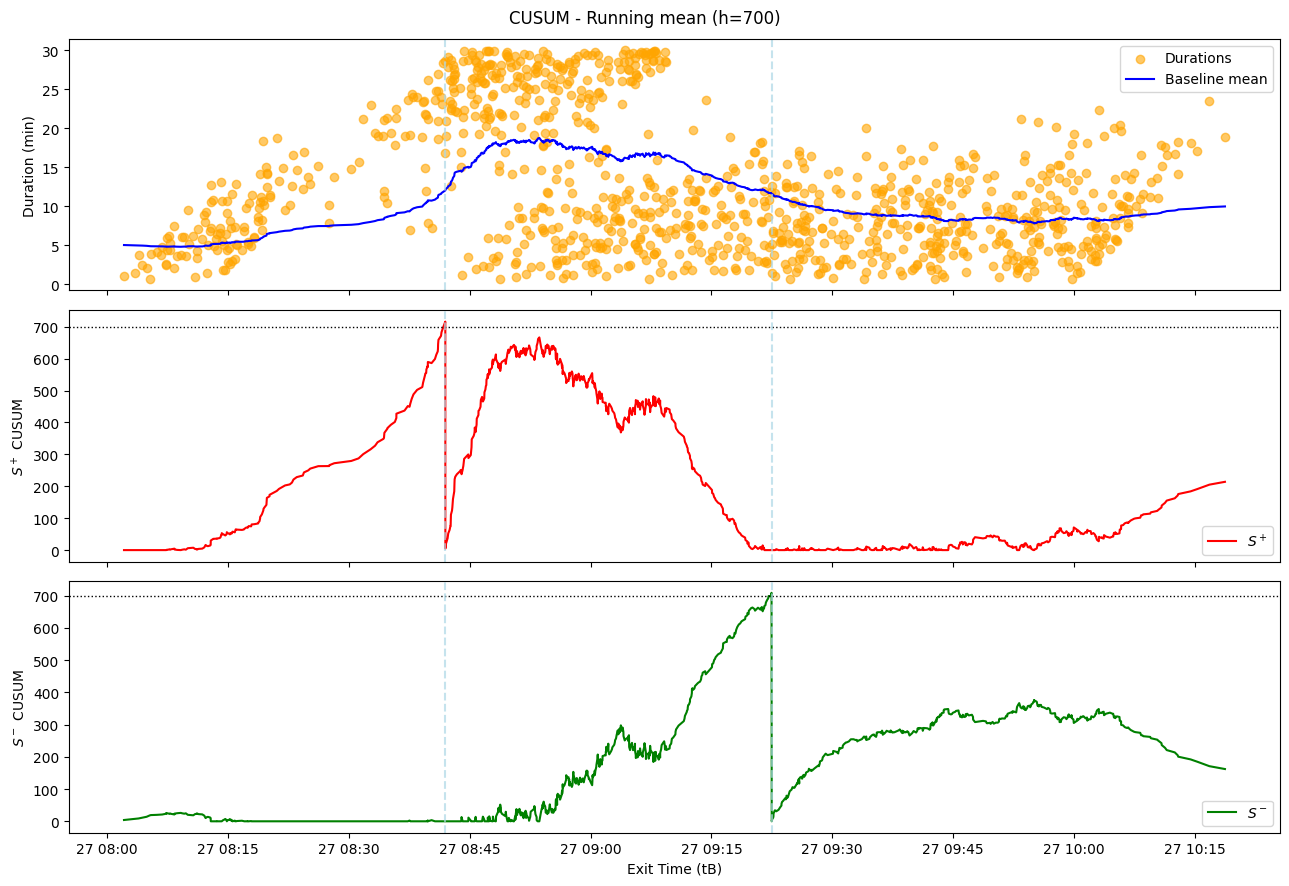

In [116]:
import matplotlib.pyplot as plt
import pandas as pd


h_values = [500,600,700]

for running, case in zip([False, True], ['Fixed mean', 'Running mean']):

    plt.figure(figsize=(13, 7))

    for h in h_values:

        changepoints, S_pos, S_neg, muHist = detect_cusum(y, muInit=5, h=h, running=running, alpha=0.01)
       
        plt.clf()
        fig, axs = plt.subplots(3, 1, sharex=True, figsize=(13,9))

        # durations and mean
        axs[0].scatter(pd.to_datetime(x), y, color='orange', alpha=0.6, label='Durations')
        axs[0].plot(pd.to_datetime(x), muHist, label='Baseline mean', color='blue')
        axs[0].set_ylabel('Duration (min)')
        axs[0].legend()


        # S^+
        axs[1].plot(pd.to_datetime(x), S_pos, color='red', label='$S^+$')
        axs[1].axhline(h, color='k', linestyle=':', linewidth=1)
        axs[1].set_ylabel('$S^+$ CUSUM')
        axs[1].legend()


        # S^-
        axs[2].plot(pd.to_datetime(x), S_neg, color='green', label='$S^-$')
        axs[2].axhline(h, color='k', linestyle=':', linewidth=1)
        axs[2].set_ylabel('$S^-$ CUSUM')
        axs[2].legend()


        # detected changepoints
        for cp in changepoints:
            for ax in axs:
                ax.axvline(pd.to_datetime(x[cp]), color='lightblue', linestyle='--', alpha=0.7)
        axs[2].set_xlabel('Exit Time (tB)')
        
        plt.suptitle(f'CUSUM - {case} (h={h})')
        plt.tight_layout()
        plt.show()

### Part 3 Step 2: Implementing Page–Hinkley

The latest version of our CUSUM implementation already looks a lot like the **Page–Hinkley test**, but Page–Hinkley adds a few extra features that make it more robust in practice:

* It introduces a **tolerance parameter (\delta)** that ignores small fluctuations around the mean, reducing false alarms.
* It explicitly tracks the **minimum of the cumulative statistic** so that only sustained upward deviations trigger detection.
* It uses a **forgetting factor (\alpha)** to allow the reference mean to adapt slowly over time.
* It requires a **minimum number of samples** before it starts checking for drift, so the estimate of the mean is stable.

---

Luckily, Page–Hinkley is common enough that an off-the-shelf implementation exists in the `river` package. You can initialize it with:

```python
ph = PageHinkley(min_instances=5, delta=0.005, threshold=threshold, alpha=alpha)
```

where the hyperparameters control:

* **`min_instances`** – minimum number of data points before detection begins.
* **`delta`** – tolerance for small changes (higher = less sensitive, lower = more sensitive).
* **`threshold`** – the decision threshold (higher = fewer detections, lower = more detections).
* **`alpha`** – forgetting factor for the running mean (how quickly the baseline adapts).

---

**Your coding task:**

1. Write a function that takes a sequence of data and returns the detected changepoints, using Page–Hinkley. A basic template is:

   ```python
   def detect_page_hinkley(y, min_instances=5, delta=0.005, threshold=threshold, alpha=alpha):
       ph = PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold, alpha=alpha)
       change_points = []
       for i, val in enumerate(y):
           ph.update(val)
           if ph.drift_detected:
               change_points.append(i)
       return change_points
   ```

2. Run this detector with **different choices of hyperparameters** (e.g. different values of `delta` and `threshold`) and plot the results:

   * Show the original time series.
   * Overlay vertical dashed lines at the detected changepoints.
   * Compare how the number and timing of detections changes with different settings.

---

**Discussion Questions:**

1. How does the tolerance parameter (\delta) help reduce false alarms compared to plain CUSUM?
2. What trade-off do you observe when increasing the threshold? (Think: sensitivity vs. missed detections.)
3. Why might the forgetting factor (\alpha) be useful in non-stationary traffic data?
4. What are the advantages and disadvantages to using a package, over writing your own code from scratch, for these more simple statistical tests?


In [117]:
from river.drift import PageHinkley

def detectPageHinkley(y, min_instances=5, delta=0.005, threshold=0.2, alpha=0.01):
    ph = PageHinkley(min_instances=min_instances, delta=delta, threshold=threshold, alpha=alpha)
    changePoints = []
    for i, val in enumerate(y):
        ph.update(val)
        if ph.drift_detected:
            changePoints.append(i)
    return changePoints

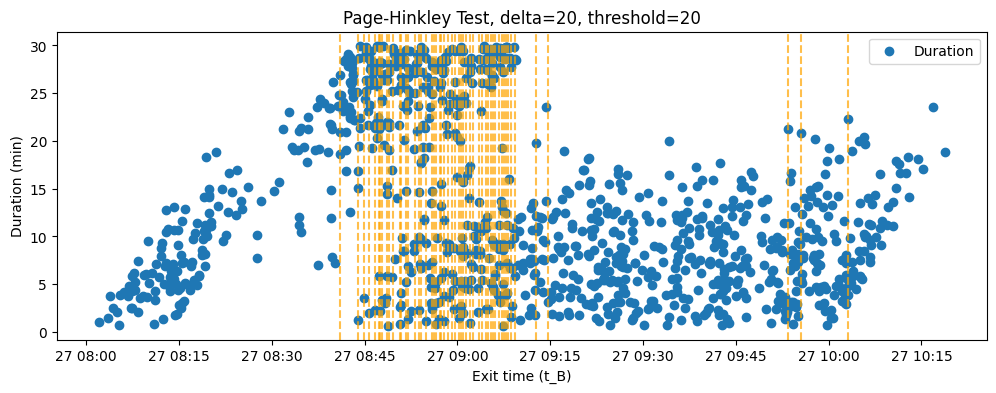

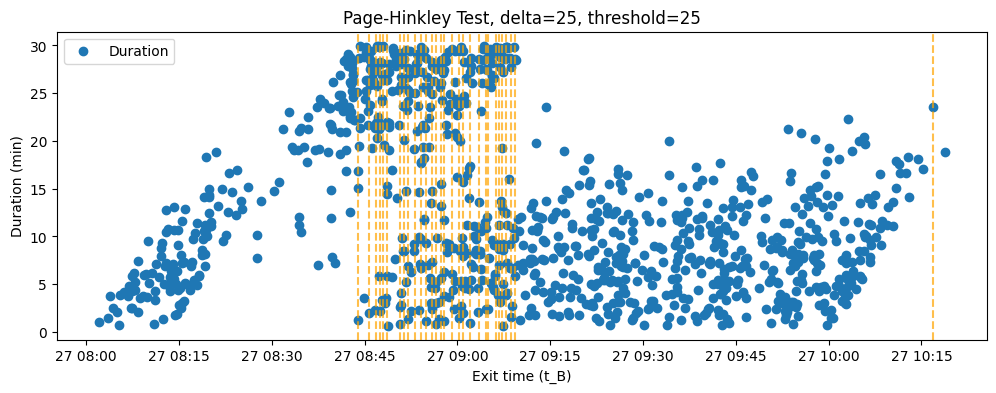

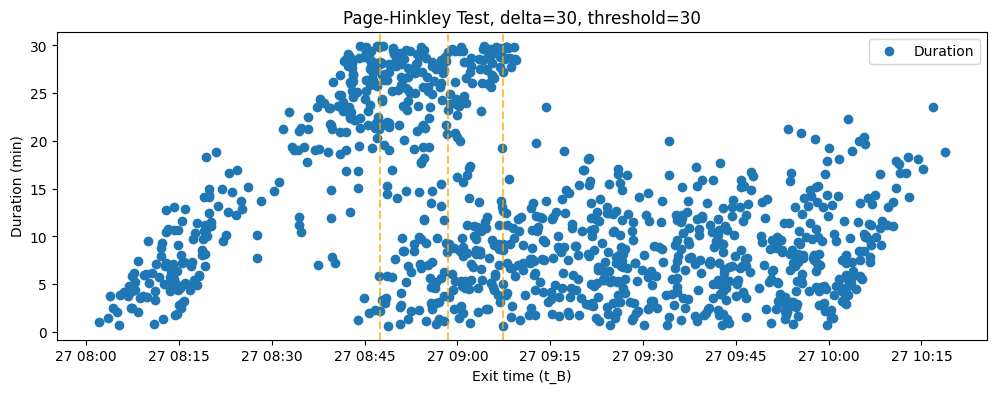

In [118]:
import matplotlib.pyplot as plt
import pandas as pd


x_timestamps = pd.to_datetime(x)  

Params = [
    {'delta': 20, 'threshold': 20},
    {'delta': 25, 'threshold': 25},
    {'delta': 30, 'threshold': 30},
]

for params in Params:
    changePoints = detectPageHinkley(
        y,
        min_instances=5,
        delta=params['delta'],
        threshold=params['threshold'],
        alpha=0.01
    )

    plt.figure(figsize=(12,4))
    plt.scatter(x_timestamps, y, label='Duration')

    for cp in changePoints:
        plt.axvline(x_timestamps[cp], color='orange', linestyle='--', alpha=0.7)

    plt.xlabel('Exit time (t_B)')
    plt.ylabel('Duration (min)')
    plt.title(f"Page-Hinkley Test, delta={params['delta']}, threshold={params['threshold']}")
    plt.legend()
    plt.show()

### Part 3 Step 3: Implementing PELT

So far we have focused on **online changepoint detection methods** such as CUSUM and Page–Hinkley. These operate in real time: as soon as each new data point arrives, they update a statistic and may trigger a detection. This makes them lightweight and fast, but they only look at the *past* — they do not reconsider earlier points in light of new evidence.

By contrast, the **PELT (Pruned Exact Linear Time)** algorithm is an **offline method**. This means it assumes the *entire sequence is available in advance* and then finds the segmentation that best explains the whole dataset.

* **Objective:** PELT tries to minimize

  $$
  \mathrm{Total Cost} = \sum_{\text{segments}} \text{cost(segment)} + \beta \times #(\text{changepoints}),
  $$
  
  where the cost of a segment depends on the model (e.g., squared error), and (\beta) (the *penalty*) controls how many changepoints are favored.

* **How it is solved:**
  Dynamic programming over all segmentations is expensive, but PELT uses a **pruning rule** to discard impossible candidates. This makes the algorithm nearly linear in practice while still finding the globally optimal set of changepoints.

---

**Your coding task:**

You are given the detection function:

```python
def detect_pelt(y, penalty=5):
    model = "rbf"
    algo = rpt.Pelt(model=model).fit(y)
    return algo.predict(pen=penalty)
```

1. Write code to generate a synthetic sequence with a few shifts in the mean.
2. For several penalty values, run `detect_pelt` and plot the results.
3. In each subplot, show the original time series and overlay vertical dashed lines at the detected changepoints.

---

**Discussion Questions:**

1. How does the choice of penalty affect the number of detected changepoints?
2. What are the advantages of an offline method like PELT compared to online methods such as Page–Hinkley?
3. In what situations would you prefer an online detector over an offline one? And vice versa?


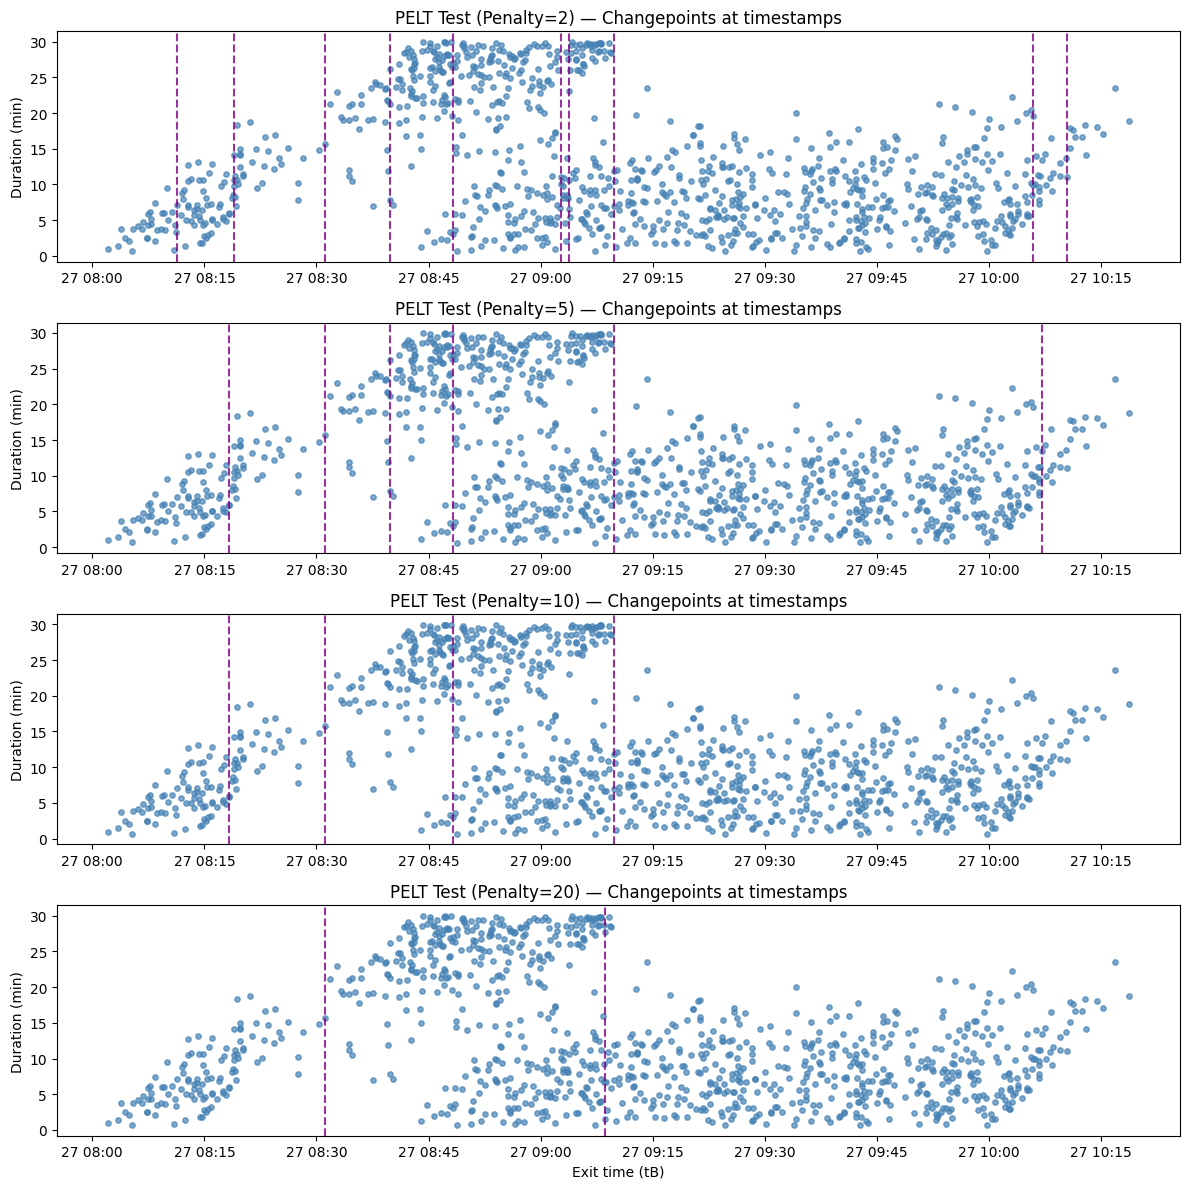

In [119]:
import ruptures as rpt

def detect_pelt(y, penalty=5):
    model = "rbf"
    algo = rpt.Pelt(model=model).fit(y)
    return algo.predict(pen=penalty)


y_arr = np.array(y)
x_timestamps = pd.to_datetime(x)
penalties = [2, 5, 10, 20]

plt.figure(figsize=(12, 12))

for i, pen in enumerate(penalties, 1):

    cps = detect_pelt(y_arr, penalty=pen)
    cps = [cp for cp in cps if cp < len(y_arr)] 

    plt.subplot(len(penalties), 1, i)

    
    plt.scatter(x_timestamps, y_arr, color="steelblue", s=15, alpha=0.7)

    for cp in cps:
        plt.axvline(x_timestamps[cp], color="purple", linestyle="--", alpha=0.8)

    plt.title(f"PELT Test (Penalty={pen}) — Changepoints at timestamps")
    plt.ylabel("Duration (min)")
    if i == len(penalties):
        plt.xlabel("Exit time (tB)")

plt.tight_layout()
plt.show()